<div style="line-height:0.5">
<h1 style="color:#BF66F2 ">  Convolutional Neural Networks in PyTorch 3 </h1>
<h4> </h4>
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> to(device) CUDA + nn.Module parameters() + zero_grad() + MSELoss +  transforms.Compose pipeline
</span>

</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
class Net_CNN(nn.Module):
    """ Convolutional Neural Network model.
    
    Details: 
    The model has the following layers:
        - conv1: A convolutional layer with 1 input channel, 6 output channels, and a kernel size of 5x5.\\
        This layer applies a set of learnable filters to the input image to extract features.

        - conv2: Another convolutional layer with 6 input channels (i.e., the output channels of conv1),\\ 
        16 output channels, and a kernel size of 5x5.\\ 
        This layer applies another set of learnable filters to the output of conv1 to extract more complex features.

        - fc1: A fully connected (linear) layer with 400 input features (i.e., the size of the output of conv2),\\
        120 output features, and a bias term.\\ 
        This layer applies a linear transformation to the input features.
        
        - fc2: Another fully connected layer with 120 input features (i.e., the output of fc1), 84 output features, and a bias term.
        
        - fc3: The final fully connected layer, which has 84 input features (i.e., the output of fc2) and 10 output features.\\ 
        The output of this layer represents the predicted probabilities for each of the 10 classes of the dataset.
    """
    def __init__(self):
        """ Initialize the neural network layers and architecture.\\ 
        # 1 input image channel, 6 output channels, 5x5 square convolution.
        """
        super(Net, self).__init__()
		# Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 6, 5)
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
		# Define the first fully connected layer (multiply for 5*5 from image dimension) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
		# Define the second fully connected layer
        self.fc2 = nn.Linear(120, 84)
        # Define the third fully connected layer (output layer)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """ Forward pass of the neural network.

        Parameters:
            Input data tensor of shape (batch_size, 1, 32, 32)

        Details:
            - Apply the first convolutional layer followed by ReLU activation and max-pooling (over a (2, 2) window)\\
            The 1st pooling layer performs down-sampling on the feature maps produced by the convolutional layers. 
            
            - Apply the second convolutional layer followed by ReLU activation and max-pooling
            
            - Flatten the tensor to prepare for fully connected layers, except the batch dimension.\\
            The size of the flattened tensor is calculated based on the number of channels in the feature maps,\\
            which is now 16 instead of 6.

            - Apply the first fully connected layer followed by ReLU activation
            - Apply the second fully connected layer followed by ReLU activation
            - Apply the third fully connected layer (output layer)
        
        Returns:
            Output tensor after passing through the network with shape (batch_size, 10)
        """        
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # when size is a square, it is possible to specify a single number
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net_CNN()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


**Note** <br>
There is no need to define in a custom class the "backward function" (where gradients are computed) <br>
in the same way of the forward pass, since it is automatically defined by using the 'autograd' option. 

In [8]:
# Get the learnable parameters of a model 
params = list(net.parameters())
print(len(params))
# Get conv1's weights
print(params[0].size())  

10
torch.Size([6, 1, 5, 5])


<h2 style="color:#BF66F2 "> <u> Example #1 </u></h2>

<h2 style="color:#BF66F2 "> First trial </h2>
Using a random 32x32 input

**Note:** <br>
The expected input size of this net (LeNet) is 32x32. <br> 
To use this net on the MNIST dataset, images from the dataset need to reshaped to 32x32.

In [9]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0172,  0.0541,  0.1441,  0.0107, -0.0347,  0.1515, -0.0458, -0.0320,
         -0.0692,  0.0232]], grad_fn=<AddmmBackward0>)


<h3 style="color:#BF66F2 "> => Backpropagation </h3>

In [10]:
""" Perform backpropagation.
N.B.
Set the gradients of all the learnable parameters in the NN to zero, to ensure that the gradients 
are initialized to zero before backpropagation.
It is essential to clear the gradients from the previous iteration to accumulate 
the new gradients correctly during the current iteration. 
"""
# Reset the gradient buffers of all parameters
net.zero_grad()
# Backprop with random gradients
out.backward(torch.randn(1, 10))

<h3 style="color:#BF66F2 "> => Loss </h3>

In [11]:
output = net(input)
## Create a dummy target, just for example, with same shape as the one of the output tensor
target = torch.randn(10)  
target = target.view(1, -1)  

# Choose the mean squared error (with L2 norm) as loss
criterion = nn.MSELoss()
# Calculate the loss 
loss = criterion(output, target)
loss

tensor(1.2580, grad_fn=<MseLossBackward0>)


In [12]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])                        # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])   # ReLU

In [ ]:
""" Set to zero the gradient buffers of all parameters, to clear the existing gradients;
otherwise, gradients will be accumulated to existing gradients.
"""
net.zero_grad()    

In [13]:
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 0.0006,  0.0096, -0.0075,  0.0205,  0.0174,  0.0004])


<h3 style="color:#BF66F2 "> => Update weights </h3>
The simplest update rule used in practice is the Stochastic Gradient Descent (SGD)

In [14]:
""" Hebbian Rule => weight = weight - learning_rate * gradient """

learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [15]:
""" Calculate Loss """
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
print(optimizer)
optimizer.zero_grad() 
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() 

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


**Recap: CIFAR10** <br>
Popular image classification dataset that consists of 60,000 32x32 color images in 10 classes, <br> 
with 6,000 images per class. <br> 
The dataset is split into 50,000 training images and 10,000 testing images. <br>

<div style="line-height:0.5">
It contains images of:
</div>
<div style="line-height:1.2">

- airplanes
- automobiles
- birds
- cats
- deers
- dogs
- frogs
- horses
- ships
- trucks
</div>

<div style="line-height:0.2">
<h3 style="color:#BF66F2 "> => Pipeline </h3>
<div style="line-height:1.5">
It is used to combine multiple transformations into a single operation. <br>
The pipeline can then be applied to a dataset using the transform argument of the dataset class, such as torchvision.datasets <br>
</div>
</div>

In [16]:
""" PyTorch data transformation pipeline, defined using the transforms.Compose() function. 

The pipeline consists of two data transformations:
1)
transforms.ToTensor(): This transformation converts the input image data (which is in the form of a PIL image) into a PyTorch tensor. 
The tensor is a multi-dimensional array that can be easily processed by a deep learning model.
2)
transforms.Normalize(): 
This transformation normalizes the pixel values of the tensor to have a mean of 0.5 and a standard deviation of 0.5. 
This helps to reduce the effect of lighting variations and other image artifacts, and can improve the performance of the model.
"""

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:12<00:00, 13118665.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Note:** <br>
By default, the DataLoader class shuffles the data before each epoch, which means that each batch returned by the iterator will contain <br> a random selection of data from the dataset. <br>
This randomness is controlled by the shuffle argument of the DataLoader class, which is set to True by default for the trainloader object in the code. <br>
Therefore, by calling next(dataiter), it returns a random batch of images and labels from the CIFAR10 training dataset, <br>
which are then passed to the imshow function to display the images and print the corresponding labels.

In [ ]:
def imshow(img):
    """ Display an image using matplotlib. """
    # Unnormalize pixel values of tensors (the image should be in the range [-1, 1])
    img = img / 2 + 0.5
    # Convert the tensor to a NumPy array
    npimg = img.numpy()
    # Transpose the NumPy array to the format (height, width, channels)
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

**Recap:**
The trainloader is a DataLoader pytorch object, that is used to load batches of training data from the dataset

In [ ]:
# Get some random training images
dataiter = iter(trainloader) 
images, labels = next(dataiter)

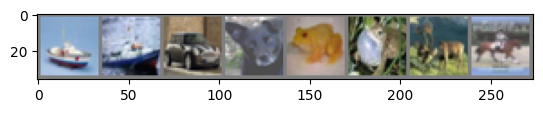

ship  ship  car   dog   frog  frog  deer  horse


In [17]:
""" Show images and labels.
The resulting grid is a PyTorch tensor of shape (channels, height, width) that contains all the images in the batch arranged in a grid.
"""
imshow(torchvision.utils.make_grid(images)) 
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

<h2 style="color:#BF66F2 "> <u> Example #2 </u></h2>

The first Net_CNN model was designed to take 1-channel (grayscale) images as input, <br> 
now providing it with 3-channel (RGB) images, it means that the network may not be able to handle the additional information in the input images. 
<br>
When a neural network is designed to take grayscale images as input, it expects each input image to have a single color channel <br> and will typically have a single channel as input. <br>
The network will learn to extract features from the grayscale images that are relevant to the task at hand, such as object recognition or image segmentation. <br>

However, if you provide the network with 3-channel RGB images, each input image will have 3 color channels (red, green, and blue), <br>
which contain additional information that the network may not be able to handle. This can result in poor performance <br> or even failure of the network to learn the task. <br>
To handle 3-channel RGB images, the Net class should be modifed (its architecture) to take into account the additional information in the input images. <br>
This could involve adding more convolutional layers or modifying the size of the filters to accommodate the additional channels.

In [2]:
class Net2_CNN(nn.Module):
    """ Another CNN Neural Network model.

    Attributes:
        - conv1: First convolutional layer [nn.Conv2d]
        - pool: Max pooling layer [nn.MaxPool2d]
        - conv2: Second convolutional layer [nn.Conv2d]
        - fc1: First fully connected layer [nn.Linear]
        - fc2: Second fully connected layer [nn.Linear]
        - fc3: Third fully connected layer [nn.Linear]

    Details:
        The nn.MaxPool2d layer computes the maximum value of each non-overlapping rectangular region (or kernel) of the feature maps.\\ 
        The size of the kernel and the amount of stride (or step size) between each kernel\\ 
        determine the amount of down-sampling performed by the layer.
    """

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """ Perform the forward pass of the Net2_CNN model.

        Args:
            Input tensor of shape (batch_size, channels, height, width)

        Details: 
            - Apply convolution, ReLU activation, and max pooling
            - Apply convolution, ReLU activation, and max pooling
            - Flatten the tensor
            - Apply fully connected layer and ReLU activation
            - Apply fully connected layer and ReLU activation
            - Apply the final fully connected layer
        
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))  
        x = self.fc3(x) 
        return x

In [ ]:
net = Net2_CNN()
net

In [19]:
""" Loss function definition """ 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

<h3 style="color:#BF66F2 "> => Training </h3>

In [20]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.133
[1,  4000] loss: 1.747
[1,  6000] loss: 1.584
[2,  2000] loss: 1.496
[2,  4000] loss: 1.418
[2,  6000] loss: 1.365
Finished Training


In [21]:
%%script echo Skipping: not necessary for now

""" Save the model on drive instead of a local path """
from google.colab import drive
drive.mount('/content/gdrive')
torch.save(net.state_dict(), 'model.pt')

Mounted at /content/gdrive


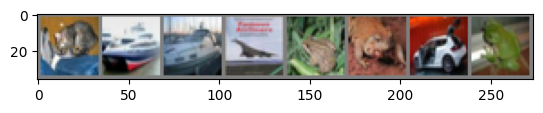

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 


In [22]:
""" Try the network on test data """
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [23]:
net_retrieved = Net2_CNN()
net_retrieved.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [24]:
outputs = net_retrieved(images)
outputs

tensor([[-0.5392, -2.2994,  0.5896,  1.6885, -0.0176,  1.1395, -0.0923,  0.1317,
         -0.5769, -1.1495],
        [ 2.6404,  4.4065, -1.8336, -1.8368, -2.1973, -3.8246, -3.1073, -4.2289,
          5.4465,  4.0669],
        [ 1.5843,  3.3795, -0.7273, -1.0476, -1.4249, -2.2961, -2.4145, -2.1054,
          2.1153,  2.7280],
        [ 3.7270,  1.0356, -0.2707, -1.4138, -0.6514, -2.8778, -2.3379, -2.4003,
          4.7605,  1.2528],
        [-2.2564, -2.3759,  2.1277,  1.6725,  3.2145,  1.3913,  3.2507, -0.4022,
         -3.6154, -4.6422],
        [ 0.0734, -1.4470,  0.4732,  0.3762,  0.7139, -0.2327,  1.9279, -0.7115,
         -0.2792, -1.0014],
        [-0.3929,  3.3361, -1.2602,  0.1944, -1.0799, -0.2978, -0.7294, -1.5765,
         -0.7239,  2.1779],
        [-0.5237, -2.2803,  1.8223,  0.6490,  2.0392,  0.0617,  2.8359, -0.3144,
         -1.7489, -2.6620]], grad_fn=<AddmmBackward0>)

In [25]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(8)))

Predicted:  cat   ship  car   ship  frog  frog  car   frog 


<h3 style="color:#BF66F2 "> => Metrics </h3>

In [26]:
""" Check the network performances (accuracy) on the whole dataset.
N.B. => (no_grad option)
Since there is no training, there is no need to calculate the gradients for our outputs. 
"""
correct, total = 0, 0

# Disable gradient calculation
with torch.no_grad():
    for data in testloader:
        # Unpack the input images and their corresponding labels
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = net_retrieved(images) 
        # Get the predicted label, by finding the class with the highest energy
        # (the maximum value along the second dimension of the output tensor).
        _, predicted = torch.max(outputs.data, 1) 
        # Increment the total count by the batch size (number of labels)
        total += labels.size(0)
        # Count the number of correct predictions in the batch and add it to the running total
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 52 %


In [27]:
""" Check the classes that performed well, and the classes that did not perform well. """

## Prepare predictions counters for each class:
    # Initialize a dictionary to keep track of correct predictions per class
    # Initialize a dictionary to keep track of total predictions per class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Disable gradient calculation as before, since we're only doing inference
with torch.no_grad():
    # Iterate over the test data
    for data in testloader:
        # Unpack the input images and their corresponding labels
        images, labels = data
        # Perform inference on the network using the input images
        outputs = net_retrieved(images)
        # Get the predicted labels by finding the maximum value along the second dimension of the output tensor
        _, predictions = torch.max(outputs, 1)
        #### Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            # Check if the prediction matches the true label and increment the right counter for the corresponding class
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 60.1 %
Accuracy for class: car   is 65.3 %
Accuracy for class: bird  is 22.6 %
Accuracy for class: cat   is 36.4 %
Accuracy for class: deer  is 35.8 %
Accuracy for class: dog   is 44.8 %
Accuracy for class: frog  is 69.0 %
Accuracy for class: horse is 67.2 %
Accuracy for class: ship  is 60.9 %
Accuracy for class: truck is 66.1 %


In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

cuda:0


In [29]:
%%script echo Skipping, since not necessary.
# Restart the kernel and to run again imports' cell
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [30]:
# Recursively go over all modules and convert their parameters and buffers to CUDA tensors
net_retrieved.to(device)
# Send the inputs and targets at every step to the GPU
inputs, labels = data[0].to(device), data[1].to(device) 